# Visualization of the PoseTrack dataset

In this notebook, we visualize PoseTrack annotations.

The PoseTrack dataset annotations are provided in a MS COCO compatible annotation format and can be handled directly using the pycocotools (https://github.com/cocodataset/cocoapi). This package must be installed for this notebook to work.

In [35]:
%matplotlib inline

import os.path as path
import os
import json
from random import randint
import time

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from skimage.draw import polygon
import skimage.io as sio
from pycocotools.coco import COCO

In [36]:
# Adjust these two variables to:
# the root folder of the posetrack data (must contain the 'images' subfolder)
posetrack_home_fp = path.expanduser('~/IMAGES/posetrack2/releases/posetrack18_v0.15/posetrack_data')

# the annotations folder (must contain 'train', 'val' and 'test' subfolders)
posetrack_annotations_fp = os.path.join(posetrack_home_fp, 'annotations')

assert(os.path.exists(posetrack_home_fp))
assert(os.path.exists(posetrack_annotations_fp))

Read in an annotation file from PoseTrack:

In [37]:
# Read a PoseTrack sequence.
coco = COCO(path.join(posetrack_annotations_fp, 'val/024577_mpii_test.json'))
#coco = COCO(path.join(posetrack_annotations_fp, 'test/023732_mpii_test.json'))

# or load the full database.
# coco = COCO(path.join(posetrack_annotations_fp, 'posetrack.json'))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Let's filter out images that have no annotations and retrieve a specific sequence:

In [38]:
img_ids = coco.getImgIds()
imgs = coco.loadImgs(img_ids)

In [39]:
# Execute this line to see all available sequence IDs.
np.unique([img['vid_id'] for img in imgs])

array([u'023732'], 
      dtype='<U6')

In [40]:
posetrack_images = []
for img in imgs:
    if not img['is_labeled']:  # or img['vid_id'] != '000015':  # Uncomment to filter for a sequence.
        pass
    else:
        posetrack_images.append(img)

In [41]:
len(posetrack_images)

60

We need a slighly refined `showAnns` function to respect the track_ids.

In [42]:
def showAnns(anns, coco):
    """
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None
    """
    from matplotlib.collections import PatchCollection
    if len(anns) == 0:
        return 0
    if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
        datasetType = 'instances'
    elif 'caption' in anns[0]:
        datasetType = 'captions'
    else:
        raise Exception('datasetType not supported')
    if datasetType == 'instances':
        ax = plt.gca()
        ax.set_autoscale_on(False)
        polygons = []
        color = []
        np.random.seed(1)
        color_coeffs = np.random.random((31, 3))
        for ann_idx, ann in enumerate(anns):
            c_assoc = ann['track_id'] * 97 % 31
            c = (color_coeffs[c_assoc:c_assoc+1, :]*0.6+0.4).tolist()[0]
            if 'keypoints' in ann and type(ann['keypoints']) == list:
                # turn skeleton into zero-based index
                sks = np.array(coco.loadCats(ann['category_id'])[0]['skeleton'])-1
                kp = np.array(ann['keypoints'])
                x = kp[0::3]
                y = kp[1::3]
                v = kp[2::3]
                for sk in sks:
                    if np.all(v[sk]>0):
                        plt.plot(x[sk],y[sk], linewidth=3, color=c)
                plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
                plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)
        p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
        ax.add_collection(p)
        p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
        ax.add_collection(p)
    elif datasetType == 'captions':
        for ann in anns:
            print(ann['caption'])

Now let's visualize the first 20 images of the sequence:

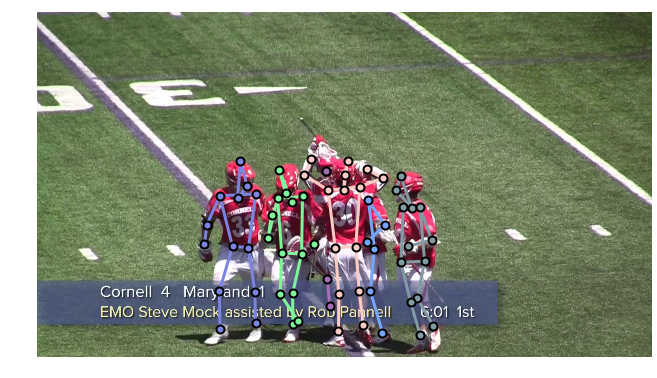

In [43]:
fig = plt.figure(figsize=[11, 11])
for image_idx, selected_im in enumerate(posetrack_images[:20]):
    ann_ids = coco.getAnnIds(imgIds=selected_im['id'])
    anns = coco.loadAnns(ann_ids)
    # Load image.
    img = sio.imread(path.join(posetrack_home_fp, selected_im['file_name']))
    # Visualize ignore regions if present.
    if 'ignore_regions_x' in selected_im.keys():
        for region_x, region_y in zip(selected_im['ignore_regions_x'], selected_im['ignore_regions_y']):
            rr, cc = polygon(region_y, region_x, img.shape)
            img[rr, cc, 1] = 128 + img[rr, cc, 1]/2
    # Display.
    plt.clf()
    plt.axis('off')
    plt.imshow(img)
    # Visualize keypoints.
    showAnns(anns, coco)
    # If you want to save the visualizations somewhere:
    # plt.savefig("vis_{:04d}.png".format(image_idx))
    # Frame updates.
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1. / 10.)
    # If you want to just look at the first image, uncomment:
    # break
plt.close()